<a href="https://colab.research.google.com/github/FerArvizu29/Clustering_Moviles/blob/main/SegmentacionMoviles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto. Análisis y segmentación de gamas de teléfonos móviles.**
### Por: Arvizu Vargas Fernando.



In [55]:
# Base de datos.
import kagglehub

# Librerías a utilizar.
import pandas as pd
import numpy as np

# Gráficas.
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento.
import re

# Modelos de ML y métricas.
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

## Importar datos y limpiarlos.

Montamos drive para leer la base de datos.

In [56]:
path = kagglehub.dataset_download("abdulmalik1518/mobiles-dataset-2025")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mobiles-dataset-2025' dataset.
Path to dataset files: /kaggle/input/mobiles-dataset-2025


In [57]:
df_unprocessed = pd.read_csv("/kaggle/input/mobiles-dataset-2025/Mobiles Dataset (2025).csv", encoding='latin1')
df_unprocessed

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year
0,Apple,iPhone 16 128GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 224,999","INR 79,999","CNY 5,799",USD 799,"AED 2,799",2024
1,Apple,iPhone 16 256GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 234,999","INR 84,999","CNY 6,099",USD 849,"AED 2,999",2024
2,Apple,iPhone 16 512GB,174g,6GB,12MP,48MP,A17 Bionic,"3,600mAh",6.1 inches,"PKR 244,999","INR 89,999","CNY 6,499",USD 899,"AED 3,199",2024
3,Apple,iPhone 16 Plus 128GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 249,999","INR 89,999","CNY 6,199",USD 899,"AED 3,199",2024
4,Apple,iPhone 16 Plus 256GB,203g,6GB,12MP,48MP,A17 Bionic,"4,200mAh",6.7 inches,"PKR 259,999","INR 94,999","CNY 6,499",USD 949,"AED 3,399",2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,Poco,Pad 5G 128GB,571g,8GB,8MP,8MP,Snapdragon 7s Gen 2,"10,000mAh",12.1 inches,"PKR 66,220","INR 23,999","CNY 2,099",USD 280,"AED 1,029",2024
926,Poco,Pad 5G 256GB,571g,8GB,8MP,8MP,Snapdragon 7s Gen 2,"10,000mAh",12.1 inches,"PKR 71,220","INR 25,999","CNY 2,299",USD 300,"AED 1,099",2024
927,Samsung,Galaxy Z Fold6 256GB,239g,12GB,"10MP, 4MP (UDC)",50MP,Snapdragon 8 Gen 3,4400mAh,7.6 inches,"PKR 604,999","INR 164,999","¥13,999","USD 1,899","AED 7,199",2024
928,Samsung,Galaxy Z Fold6 512GB,239g,12GB,"10MP, 4MP (UDC)",50MP,Snapdragon 8 Gen 3,4400mAh,7.6 inches,"PKR 544,999","INR 176,999","CNY 15,999",USD 1719,"AED 7,699",2024


Definimos funciones para limpiar tipos de datos muy específicos, y procedemos con la limpieza de todas las columnas.

In [58]:
# Funciones para limpiar la RAM, la pantalla y los megapixeles de la cámara.
def clean_ram(value):
  numbers = re.findall(r'\d+', str(value))
  numbers = list(map(int, numbers))
  return sum(numbers) / len(numbers) if numbers else None

def clean_screen(value):
  match_main = re.search(r'(\d+(\.\d+)?)\s*\((main)\)', value, re.IGNORECASE)
  if match_main:
    return float(match_main.group(1))
  match_general = re.search(r'\d+(\.\d+)?', value)
  if match_general:
    return float(match_general.group(0))
  return None

def extract_mp(valor):
  numeros = re.findall(r'(\d+)', str(valor))
  if numeros:
    return int(numeros[0])
  return None

# Limpieza de los datos.
df_unprocessed['Processor'] = df_unprocessed['Processor'].astype('category')
df_unprocessed['Company Name'] = df_unprocessed['Company Name'].astype('category')
df_unprocessed["Model Name"] = df_unprocessed["Model Name"].astype('category')
df_unprocessed['RAM'] = df_unprocessed['RAM'].astype(str).apply(clean_ram).astype(float)
df_unprocessed['Battery Capacity'] = df_unprocessed['Battery Capacity'].astype(str).str.replace(',', '').str.extract(r'(\d+)')[0].astype(float)
df_unprocessed['Mobile Weight'] = df_unprocessed['Mobile Weight'].astype(str).str.replace('g', '').str.extract(r'(\d+)')[0].astype(float)
df_unprocessed['Screen Size'] = df_unprocessed['Screen Size'].astype(str).apply(clean_screen).astype(float)
df_unprocessed['Front Camera'] = df_unprocessed['Front Camera'].apply(extract_mp)
df_unprocessed['Back Camera'] = df_unprocessed['Back Camera'].apply(extract_mp)
columnas_precio = ["Launched Price (Pakistan)", "Launched Price (India)", "Launched Price (China)", "Launched Price (USA)", "Launched Price (Dubai)"]
for col in columnas_precio:
  df_unprocessed[col] = df_unprocessed[col].str.extract(r'([\d,]+)', expand=False)
  df_unprocessed[col] = df_unprocessed[col].str.replace(',', '', regex=False)
  df_unprocessed[col] = pd.to_numeric(df_unprocessed[col], errors='coerce')

In [59]:
# Verificamos los datos.
df_unprocessed

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (Pakistan),Launched Price (India),Launched Price (China),Launched Price (USA),Launched Price (Dubai),Launched Year
0,Apple,iPhone 16 128GB,174.0,6.0,12,48,A17 Bionic,3600.0,6.1,224999.0,79999,5799,799,2799,2024
1,Apple,iPhone 16 256GB,174.0,6.0,12,48,A17 Bionic,3600.0,6.1,234999.0,84999,6099,849,2999,2024
2,Apple,iPhone 16 512GB,174.0,6.0,12,48,A17 Bionic,3600.0,6.1,244999.0,89999,6499,899,3199,2024
3,Apple,iPhone 16 Plus 128GB,203.0,6.0,12,48,A17 Bionic,4200.0,6.7,249999.0,89999,6199,899,3199,2024
4,Apple,iPhone 16 Plus 256GB,203.0,6.0,12,48,A17 Bionic,4200.0,6.7,259999.0,94999,6499,949,3399,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,Poco,Pad 5G 128GB,571.0,8.0,8,8,Snapdragon 7s Gen 2,10000.0,12.1,66220.0,23999,2099,280,1029,2024
926,Poco,Pad 5G 256GB,571.0,8.0,8,8,Snapdragon 7s Gen 2,10000.0,12.1,71220.0,25999,2299,300,1099,2024
927,Samsung,Galaxy Z Fold6 256GB,239.0,12.0,10,50,Snapdragon 8 Gen 3,4400.0,7.6,604999.0,164999,13999,1899,7199,2024
928,Samsung,Galaxy Z Fold6 512GB,239.0,12.0,10,50,Snapdragon 8 Gen 3,4400.0,7.6,544999.0,176999,15999,1719,7699,2024


#### Busqueda de outliers.
Grafiquemos algunos boxplots, para ver la distribución de algunas variables.

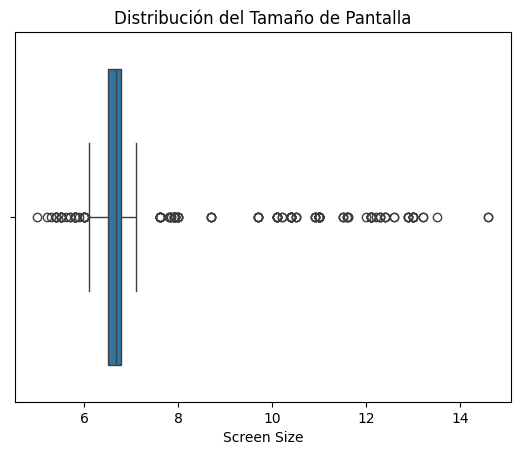

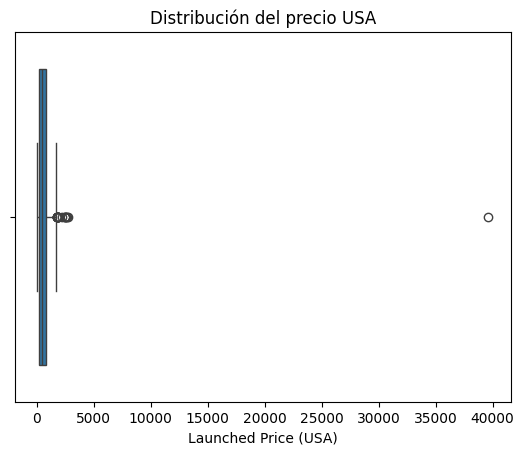

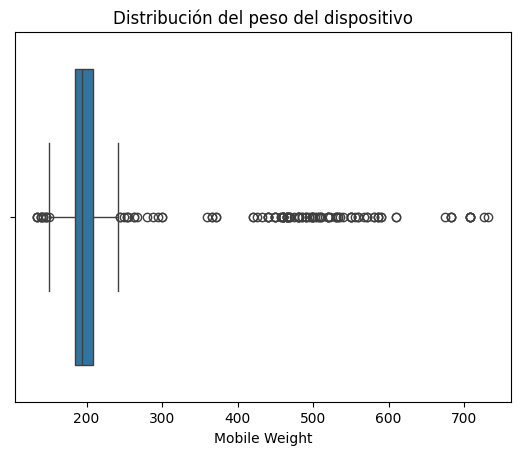

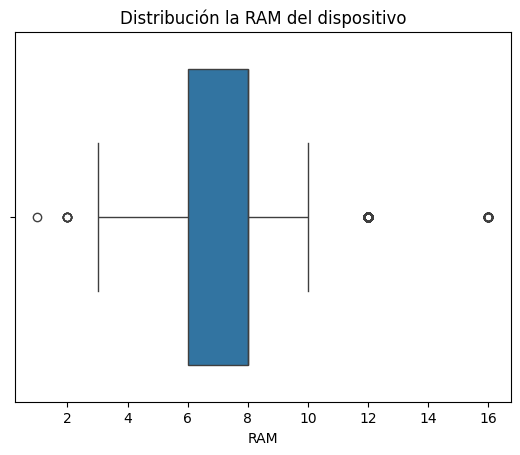

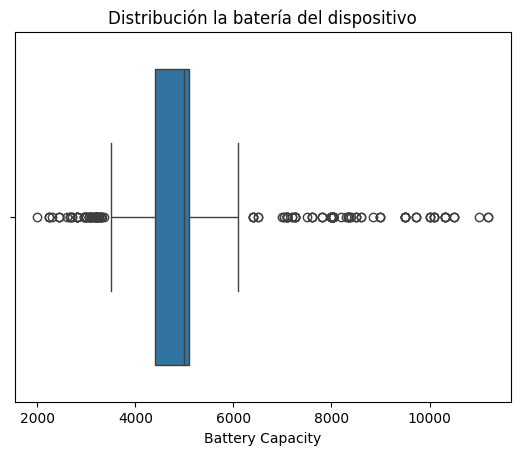

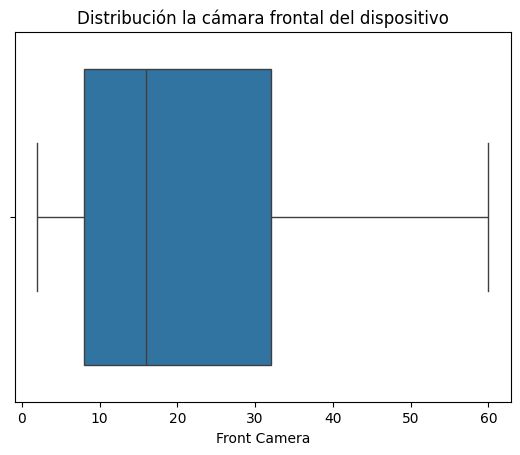

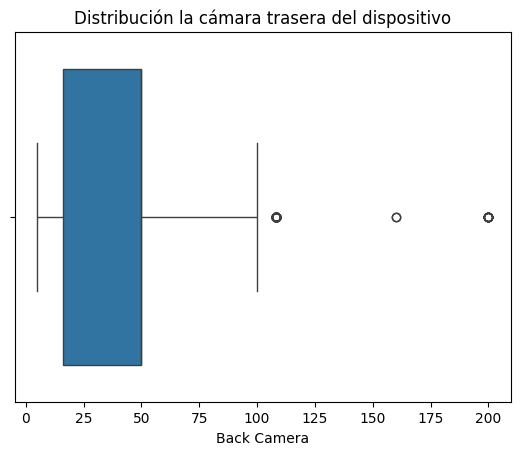

In [60]:
# Investigando el tamaño de pantalla
sns.boxplot(x=df_unprocessed['Screen Size'])
plt.title('Distribución del Tamaño de Pantalla')
plt.show()

# Investigando el precio.
sns.boxplot(x=df_unprocessed['Launched Price (USA)'])
plt.title('Distribución del precio USA')
plt.show()

# Investigando el peso.
sns.boxplot(x=df_unprocessed['Mobile Weight'])
plt.title('Distribución del peso del dispositivo')
plt.show()

# Investigando la RAM.
sns.boxplot(x=df_unprocessed['RAM'])
plt.title('Distribución la RAM del dispositivo')
plt.show()

# Investigando la batería.
sns.boxplot(x=df_unprocessed['Battery Capacity'])
plt.title('Distribución la batería del dispositivo')
plt.show()

# Investigando la cámara.
sns.boxplot(x=df_unprocessed['Front Camera'])
plt.title('Distribución la cámara frontal del dispositivo')
plt.show()

sns.boxplot(x=df_unprocessed['Back Camera'])
plt.title('Distribución la cámara trasera del dispositivo')
plt.show()

# Notamos que la batería, la pantalla y el peso del dispositivo son variables que influyen mucho o tienen mucha variabilidad.
  # Posiblemente indica la existencia de un grupo de dispositivos más grandes.
# Hay un outlier de precio, pero no lo quitaremos debido a que no tomaremos en consideración la columna de precio para el clustering.

In [61]:
df_processed = df_unprocessed[['Company Name', 'Model Name', 'Processor','Mobile Weight', 'RAM', 'Front Camera',	'Back Camera', 'Battery Capacity', 'Screen Size',	'Launched Year', 'Launched Price (USA)']]

In [62]:
df_processed.to_csv("/content/mobiles_dataset_clean.csv", index=False)

## Primer clustering para separar tablets.

Se identificó la presencia de tablets en el dataset, y se considera que estas requieren un tratamiento por separado de los teléfonos, así que se implementó una limpieza utilizando aprendizaje no supervisado.

In [63]:
# Cargamos el dataframe limpio.
df = pd.read_csv("/content/mobiles_dataset_clean.csv").reset_index(drop=True)
df_predict = df.copy()
# Quitaremos la columna de precio, por que no es relevante para el análisis. Nos quedaremos con el resto de variables numéricas.
df_numeric = df[['Mobile Weight', 'RAM', 'Front Camera',	'Back Camera', 'Battery Capacity', 'Screen Size',	'Launched Year']]
df_numeric

,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year
0,174.0,6.0,12,48,3600.0,6.1,2024
1,174.0,6.0,12,48,3600.0,6.1,2024
2,174.0,6.0,12,48,3600.0,6.1,2024
3,203.0,6.0,12,48,4200.0,6.7,2024
4,203.0,6.0,12,48,4200.0,6.7,2024
...,...,...,...,...,...,...,...
925,571.0,8.0,8,8,10000.0,12.1,2024
926,571.0,8.0,8,8,10000.0,12.1,2024
927,239.0,12.0,10,50,4400.0,7.6,2024
928,239.0,12.0,10,50,4400.0,7.6,2024


Hacemos una estandarización en los datos, para que todas las magnitudes numéricas sean comparables.

In [64]:
scaler = StandardScaler()
datos_escalados = scaler.fit_transform(df_numeric)

Aplicamos PCA para visualizar los datos.

In [65]:
pca = PCA()
pca.fit(datos_escalados)
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)
n_componentes = np.where(varianza_acumulada >= 0.73 )[0][0] + 1
print(f"Número de componentes para explicar el 73% de la varianza: {n_componentes}")

pca = PCA(n_components=2)
datos_pca = pca.fit_transform(datos_escalados)

Número de componentes para explicar el 73% de la varianza: 2


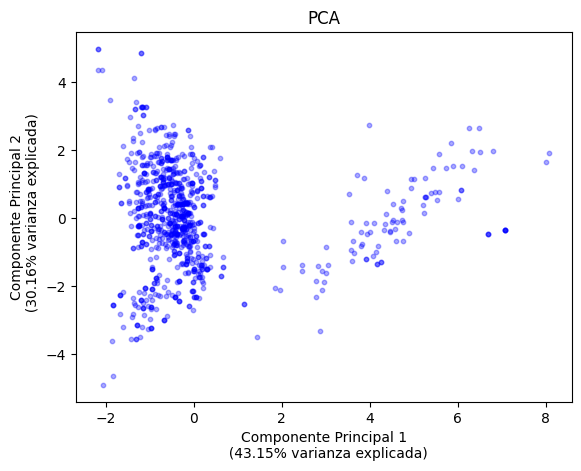

In [66]:
# Para datos sin etiqueta.
def plot_PCA(X_train, pca, title):
    # Graficar todos los puntos en un solo color, sin etiquetas
    plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.33, s=10, color='blue')
    plt.xlabel(f'Componente Principal 1\n  ({np.round(pca.explained_variance_ratio_[0]*100,2)}% varianza explicada)')
    plt.ylabel(f'Componente Principal 2\n  ({np.round(pca.explained_variance_ratio_[1]*100,2)}% varianza explicada)')
    plt.title(title)
    plt.show()

high_contrast = {0: 'red', 1: 'blue', 2: 'green'}
wong = {0: '#E69F00', 1: '#56B4E9', 2: '#009E73'}
vibrant = {0: '#FFC107', 1: '#007BFF', 2: '#DC3545'}

# Para datos con etiqueta.
def plot_PCA_labeled(X_train, y_train, title, color_map = high_contrast):
  for aux in np.unique(y_train):
    plt.scatter(X_train[y_train==aux,0],X_train[y_train==aux,1],label=f'No.{aux}', alpha=.33, s = 10, color=color_map[aux])
    pass
  plt.xlabel(f'Componente Principal 1\n  ({np.round(pca.explained_variance_ratio_[0]*100,2)}% varianza explicada)')
  plt.ylabel(f'Componente Principal 2\n  ({np.round(pca.explained_variance_ratio_[1]*100,2)}% varianza explicada)')
  plt.legend()
  plt.title(title)
  plt.show()

# Gráfica en 2 dimensiones para todos los dispositivos del dataframe.
plot_PCA(datos_pca, pca, 'PCA')

Aplicamos Hierarchical Clustering para esta tarea. (Separa mejor las tablets que K-means, el cuál se probó con k=2 y k=3)

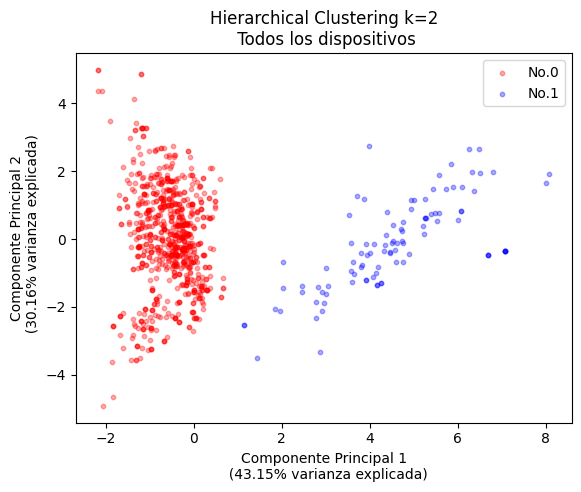

In [67]:
hierarchical = AgglomerativeClustering(n_clusters=2, linkage="ward")
hierarchical.fit(datos_escalados)
df_predict['agglomerative_2'] = hierarchical.fit_predict(datos_escalados)
plot_PCA_labeled(datos_pca, df_predict['agglomerative_2'], 'Hierarchical Clustering k=2\n Todos los dispositivos', high_contrast)

In [68]:
# Los dispositivos identificados con 1 son las tablets, decidiremos eliminar estos dispositivos.
df_predict[df_predict.agglomerative_2 == 1]

,Company Name,Model Name,Processor,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA),agglomerative_2
80,Apple,iPad Air 10.9-inch 64GB,A14 Bionic,458.0,4.0,12,12,7608.0,10.9,2020,599,1
81,Apple,iPad Air 10.9-inch 256GB,A14 Bionic,458.0,4.0,12,12,7608.0,10.9,2020,749,1
82,Apple,iPad 10.2-inch 32GB,A13 Bionic,490.0,3.0,12,8,8612.0,10.2,2020,329,1
83,Apple,iPad 10.2-inch 128GB,A13 Bionic,490.0,3.0,12,8,8612.0,10.2,2020,429,1
84,Apple,iPad Mini 7.9-inch 64GB,A12 Bionic,300.0,3.0,7,8,5124.0,7.9,2019,399,1
...,...,...,...,...,...,...,...,...,...,...,...,...
892,Honor,Pad X10 Pro,Qualcomm Snapdragon 7s Gen 2,485.0,8.0,8,13,9000.0,12.6,2024,499,1
893,Honor,MagicPad 3,Qualcomm Snapdragon 8 Gen 3,590.0,12.0,12,16,10500.0,13.0,2024,799,1
894,Honor,Pad V10,MediaTek Dimensity 9000,530.0,8.0,8,13,8500.0,12.1,2024,649,1
925,Poco,Pad 5G 128GB,Snapdragon 7s Gen 2,571.0,8.0,8,8,10000.0,12.1,2024,280,1


In [69]:
df_phones = df_predict[df_predict.agglomerative_2 == 0][['Company Name', 'Model Name', 'Processor','Mobile Weight', 'RAM', 'Front Camera',	'Back Camera', 'Battery Capacity', 'Screen Size',	'Launched Year', 'Launched Price (USA)']]
df_phones
# Nos quedamos solo con 829 dispositivos.

,Company Name,Model Name,Processor,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA)
0,Apple,iPhone 16 128GB,A17 Bionic,174.0,6.0,12,48,3600.0,6.10,2024,799
1,Apple,iPhone 16 256GB,A17 Bionic,174.0,6.0,12,48,3600.0,6.10,2024,849
2,Apple,iPhone 16 512GB,A17 Bionic,174.0,6.0,12,48,3600.0,6.10,2024,899
3,Apple,iPhone 16 Plus 128GB,A17 Bionic,203.0,6.0,12,48,4200.0,6.70,2024,899
4,Apple,iPhone 16 Plus 256GB,A17 Bionic,203.0,6.0,12,48,4200.0,6.70,2024,949
...,...,...,...,...,...,...,...,...,...,...,...
923,POCO,X7 Pro 256GB,MediaTek Dimensity 8400,207.0,8.0,20,108,6000.0,6.67,2025,399
924,POCO,M7 5G 128GB,MediaTek Dimensity 7025,198.0,6.0,8,50,5110.0,6.67,2024,229
927,Samsung,Galaxy Z Fold6 256GB,Snapdragon 8 Gen 3,239.0,12.0,10,50,4400.0,7.60,2024,1899
928,Samsung,Galaxy Z Fold6 512GB,Snapdragon 8 Gen 3,239.0,12.0,10,50,4400.0,7.60,2024,1719


Añadiremos información acerca de los procesadores, una clasificación a priori basada en su rendimiento en paginas como Antutu.

In [70]:
procesores_importantes = df_phones.Processor.value_counts().head(156).index
for element in df_phones.Processor.unique():
  print(element)

A17 Bionic
A17 Pro
A16 Bionic
A15 Bionic
A14 Bionic
A13 Bionic
A11 Bionic
A12 Bionic
Exynos 2400
Snapdragon 8 Gen 2
Exynos 2200
Snapdragon 8 Gen 1
Exynos 1380
MediaTek Dimensity 1080
MediaTek Helio G99
Exynos 850
Exynos 1280
MediaTek Helio P35
Exynos 990
Exynos 9825
Snapdragon 450
Exynos 7870
Snapdragon 425
Exynos 7570
Snapdragon 653
Snapdragon 625
Snapdragon 617
Snapdragon 888
Snapdragon 8 Gen 3
MediaTek Dimensity 9000
Snapdragon 782G
Snapdragon 695
MediaTek Dimensity 6020
Snapdragon 8+ Gen 1
MediaTek Dimensity 1300
MediaTek Dimensity 1200-AI
Snapdragon 480
Qualcomm Snapdragon 460
Snapdragon 865
Snapdragon 870
MediaTek Dimensity 900
MediaTek Dimensity 1200
Snapdragon 765G
Snapdragon 750G
Qualcomm Snapdragon 690
Snapdragon 855
Snapdragon 845
Snapdragon 835
MediaTek Dimensity 8100
Dimensity 9400
Snapdragon 778G
Dimensity 1200
Dimensity 900
Dimensity 1100
Snapdragon 710
Snapdragon 626
MediaTek Helio P22
Snapdragon 615
Snapdragon 439
Snapdragon 652
MediaTek MT6592
Snapdragon 430
Qualcomm 

In [71]:
# Agregamos manualmente benchs de procesadores para tomar esta información en cuenta durante el clustering.
processor_clusters = {
    "A17 Bionic": 5,
    "A17 Pro": 5,
    "A16 Bionic": 5,
    "A15 Bionic": 5,
    "A14 Bionic": 4,
    "A13 Bionic": 4,
    "A11 Bionic": 2,
    "A12 Bionic": 3,
    "Exynos 2400": 5,
    "Snapdragon 8 Gen 2": 5,
    "Exynos 2200": 4,
    "Snapdragon 8 Gen 1": 4,
    "Exynos 1380": 3,
    "MediaTek Dimensity 1080": 3,
    "MediaTek Helio G99": 3,
    "Exynos 850": 2,
    "Exynos 1280": 3,
    "MediaTek Helio P35": 2,
    "Exynos 990": 4,
    "Exynos 9825": 4,
    "Snapdragon 450": 2,
    "Exynos 7870": 1,
    "Snapdragon 425": 1,
    "Exynos 7570": 1,
    "Snapdragon 653": 2,
    "Snapdragon 625": 2,
    "Snapdragon 617": 2,
    "Snapdragon 888": 4,
    "Snapdragon 8 Gen 3": 5,
    "MediaTek Dimensity 9000": 5,
    "Snapdragon 782G": 3,
    "Snapdragon 695": 3,
    "MediaTek Dimensity 6020": 3,
    "Snapdragon 8+ Gen 1": 5,
    "MediaTek Dimensity 1300": 3,
    "MediaTek Dimensity 1200-AI": 3,
    "Snapdragon 480": 2,
    "Qualcomm Snapdragon 460": 2,
    "Snapdragon 865": 4,
    "Snapdragon 870": 4,
    "MediaTek Dimensity 900": 3,
    "MediaTek Dimensity 1200": 3,
    "Snapdragon 765G": 3,
    "Snapdragon 750G": 3,
    "Qualcomm Snapdragon 690": 3,
    "Snapdragon 855": 4,
    "Snapdragon 845": 4,
    "Snapdragon 835": 4,
    "MediaTek Dimensity 8100": 4,
    "Dimensity 9400": 5,
    "Snapdragon 778G": 3,
    "Dimensity 1200": 3,
    "Dimensity 900": 3,
    "Dimensity 1100": 4,
    "Snapdragon 710": 3,
    "Snapdragon 626": 2,
    "MediaTek Helio P22": 2,
    "Snapdragon 615": 2,
    "Snapdragon 439": 2,
    "Snapdragon 652": 2,
    "MediaTek MT6592": 2,
    "Snapdragon 430": 2,
    "Qualcomm Snapdragon 712": 3,
    "Qualcomm Snapdragon 675": 3,
    "MediaTek Helio P65": 2,
    "Qualcomm Snapdragon 439": 2,
    "MediaTek Helio P70": 2,
    "Qualcomm Snapdragon 710": 3,
    "Qualcomm Snapdragon 660": 2,
    "MediaTek Helio G96": 3,
    "MediaTek Helio G80": 2,
    "Qualcomm Snapdragon 870": 4,
    "Qualcomm Snapdragon 765G": 3,
    "MediaTek Dimensity 700": 2,
    "Qualcomm Snapdragon 695": 3,
    "Qualcomm Snapdragon 855": 4,
    "MediaTek Dimensity 8200": 4,
    "MediaTek Dimensity 9200": 5,
    "MediaTek Dimensity 920": 3,
    "MediaTek Helio G100": 3,
    "MediaTek Dimensity 8350": 4,
    "Snapdragon 685": 3,
    "MediaTek Dimensity 7050": 3,
    "Dimensity 7300": 4,
    "Dimensity 6300": 3,
    "Snapdragon 6s 4G Gen 1": 3,
    "Snapdragon 680 4G": 3,
    "Snapdragon 7 Gen 3": 4,
    "Dimensity 9300": 5,
    "Dimensity 9000+": 5,
    "MediaTek Dimensity 810": 3,
    "Qualcomm Snapdragon 480": 2,
    "MediaTek Dimensity 720": 2,
    "Qualcomm Snapdragon 6s Gen 1": 3,
    "MediaTek Dimensity 8000-Max": 4,
    "Qualcomm Snapdragon 768G": 3,
    "Qualcomm Snapdragon 782G": 3,
    "Qualcomm Snapdragon 8 Elite": 5,
    "Qualcomm Snapdragon 8s Gen 3": 5,
    "Qualcomm Snapdragon 7 Plus Gen 3": 4,
    "Qualcomm Snapdragon 7s Gen 3": 3,
    "MediaTek Dimensity 7300 Energy": 4,
    "Qualcomm Snapdragon 7s Gen 2": 3,
    "MediaTek Dimensity 7200": 3,
    "MediaTek Dimensity 6100+": 3,
    "Qualcomm Snapdragon 7+ Gen 2": 4,
    "Qualcomm Snapdragon 7+ Gen 3": 4,
    "Qualcomm Snapdragon 7s Gen 1": 3,
    "MediaTek Helio G88": 2,
    "MediaTek Helio G85": 2,
    "Unisoc T612": 2,
    "Qualcomm Snapdragon 680": 3,
    "Qualcomm Snapdragon 8 Gen 2": 5,
    "Snapdragon 8 Elite": 5,
    "Dimensity 9300+": 5,
    "Dimensity 8300-Ultra": 5,
    "Snapdragon 7s Gen 3": 3,
    "MediaTek Dimensity 7300-Ultra": 4,
    "Qualcomm Snapdragon 732G": 3,
    "MediaTek Dimensity 7025-Ultra": 3,
    "Unisoc T700": 2,
    "Snapdragon 662": 2,
    "Unisoc SC9863A": 2,
    "Snapdragon 460": 2,
    "Snapdragon 632": 2,
    "Helio P22": 2,
    "Snapdragon 7 Gen 1": 3,
    "Exynos 9609": 2,
    "MediaTek Helio G25": 2,
    "Snapdragon 6 Gen 3": 3,
    "MediaTek Dimensity 7300": 4,
    "MediaTek Dimensity 7025": 3,
    "Unisoc T760": 3,
    "Snapdragon 6s Gen 3": 3,
    "Snapdragon 7s Gen 2": 3,
    "Unisoc T606": 2,
    "Snapdragon 6 Gen 1": 3,
    "Snapdragon 888+ 5G": 4,
    "Snapdragon 695 5G": 3,
    "Snapdragon 480+ 5G": 2,
    "MediaTek Helio G37": 2,
    "Snapdragon 888 4G": 4,
    "Kirin 990E 5G": 4,
    "Kirin 9000 5G": 5,
    "Snapdragon 778G 4G": 3,
    "Snapdragon 8+ Gen 1 4G": 5,
    "Kirin 9000S": 4,
    "Kirin 9010": 4,
    "Snapdragon 480+": 2,
    "MediaTek G35": 2,
    "Snapdragon 670": 3,
    "Snapdragon 730G": 3,
    "Google Tensor": 3,
    "Google Tensor G2": 4,
    "Google Tensor G3": 4,
    "Google Tensor G4": 5,
    "MediaTek Helio A22": 2,
    "Unisoc SC9832E": 2,
    "MediaTek Dimensity 9200+": 5,
    "MediaTek Dimensity 8050": 4,
    "Qualcomm Snapdragon 778G": 3,
    "MediaTek Dimensity 8020": 4,
    "Unisoc T610": 2,
    "Unisoc T616": 2,
    "MediaTek Helio G70": 2,
    "MediaTek Helio A25": 2,
    "MediaTek Helio G35": 2,
    "MediaTek Helio A20": 2,
    "MediaTek Helio G90T": 3,
    "Kirin 710F": 2,
    "Kirin 985 5G": 4,
    "Kirin 990 5G": 4,
    "Kirin 820 5G": 3,
    "MediaTek Dimensity 800": 3,
    "Kirin 710A": 2,
    "MediaTek Dimensity 1000+": 4,
    "MediaTek Dimensity 800U": 3,
    "Qualcomm Snapdragon 888": 4,
    "Qualcomm Snapdragon 888+": 4,
    "Qualcomm Snapdragon 778G+": 3,
    "MediaTek MT6762G Helio G25": 2,
    "Qualcomm Snapdragon 8 Gen 1": 4,
    "MediaTek Dimensity 8000": 4,
    "Qualcomm Snapdragon 8+ Gen 1": 5,
    "Qualcomm Snapdragon 6 Gen 1": 3,
    "MediaTek Helio G36": 2,
    "Qualcomm Snapdragon 8 Gen 3": 5,
    "Qualcomm Snapdragon 7 Gen 1": 3,
    "Snapdragon 720G": 3,
    "Snapdragon 732G": 3,
    "Snapdragon 860": 4,
    "MediaTek Dimensity 1100": 4,
    "MediaTek Helio G95": 3,
    "Snapdragon 7+ Gen 2": 4,
    "Snapdragon 4 Gen 1": 3,
    "MediaTek Dimensity 8300": 5,
    "Snapdragon 8+ Gen 2": 5,
    "MediaTek Dimensity 8400": 5
}

In [72]:
# Creamos una copia para agregar los datos del bench de los procesadores.
df_phones_copy = df_phones.copy()

# Mapeamos los valores
df_phones_copy['ProcessorBench'] = df_phones_copy['Processor'].map(processor_clusters)

# Verificar cuántos NaN hay.
nan_count = df_phones_copy['ProcessorBench'].isna().sum()
total_count = len(df_phones_copy)
print(f"NaN values: {nan_count}/{total_count} ({nan_count/total_count*100:.1f}%)")

# Imputamos con mediana (3, pues nuestro ranking es en escala 1-5)
df_phones_copy['ProcessorBench'] = df_phones_copy['ProcessorBench'].fillna(3)

# 5. Verificar distribución final
print("Distribución final de clusters:")
print(df_phones_copy['ProcessorBench'].value_counts().sort_index())

df_phones_copy = df_phones_copy[['Company Name', 'Model Name', 'Processor', 'ProcessorBench', 'Mobile Weight', 'RAM', 'Front Camera',	'Back Camera', 'Battery Capacity', 'Screen Size',	'Launched Year', 'Launched Price (USA)']]

NaN values: 17/829 (2.1%)
Distribución final de clusters:
ProcessorBench
1.0      3
2.0    162
3.0    304
4.0    181
5.0    179
Name: count, dtype: int64


## Segundo clustering para clasificar por gamas de teléfonos.

Ahora, aplicaremos clustering para separar los teléfonos por gamas. Nuevamente nos quedaremos con únicamente las variables numéricas para este análisis.

Tomaremos en cuenta el procesador con los benchs asignados manualmente, y no tomamos en cuenta el tamaño de pantalla, pues no se considera relevante para asignar la gama, pues existen teléfonos de diferentes gamas con el mismo tamaño de pantalla.

In [73]:
df_phones_numeric = df_phones_copy[['Mobile Weight',
                                    'RAM',
                                    'Front Camera',
                                    'Back Camera',
                                    'ProcessorBench',
                                    'Battery Capacity',
                                    #'Screen Size',
                                    'Launched Year']]
df_phones_predict = df_phones_copy.copy()
df_phones_numeric

,Mobile Weight,RAM,Front Camera,Back Camera,ProcessorBench,Battery Capacity,Launched Year
0,174.0,6.0,12,48,5.0,3600.0,2024
1,174.0,6.0,12,48,5.0,3600.0,2024
2,174.0,6.0,12,48,5.0,3600.0,2024
3,203.0,6.0,12,48,5.0,4200.0,2024
4,203.0,6.0,12,48,5.0,4200.0,2024
...,...,...,...,...,...,...,...
923,207.0,8.0,20,108,5.0,6000.0,2025
924,198.0,6.0,8,50,3.0,5110.0,2024
927,239.0,12.0,10,50,5.0,4400.0,2024
928,239.0,12.0,10,50,5.0,4400.0,2024


Primero, preprocesemos escalando con MinMax o con Estandarización.
Usaremos PCA para visualizar nuestros datos en dos dimensiones.

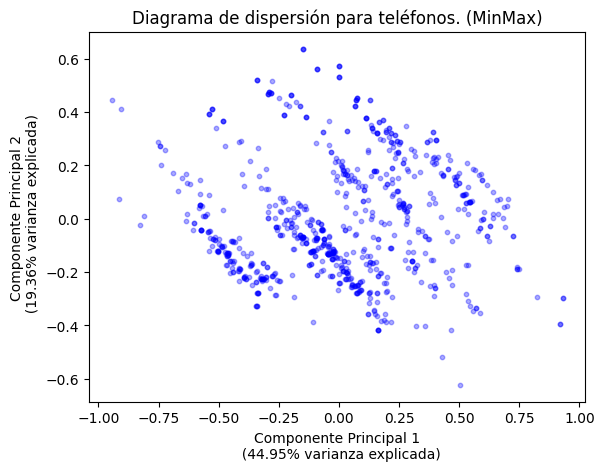

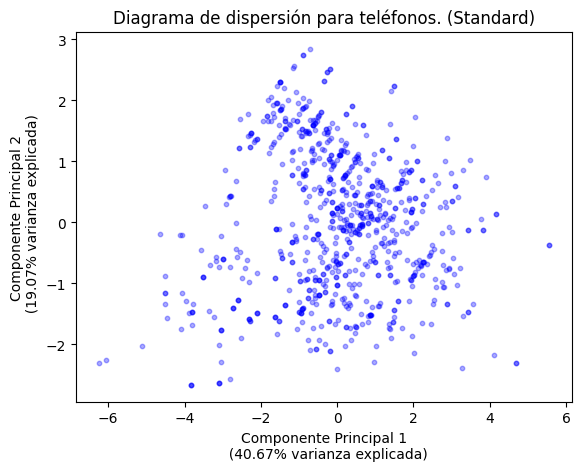

In [74]:
# Escalamos los datos.
minmax = MinMaxScaler()
datos_escalados_minmax = minmax.fit_transform(df_phones_numeric)
standard = StandardScaler()
datos_escalados_standard = standard.fit_transform(df_phones_numeric)
# Usamos PCA para visualizar ambos.
pca = PCA(n_components=2)
datos_pca_minmax = pca.fit_transform(datos_escalados_minmax)
plot_PCA(datos_pca_minmax, pca, "Diagrama de dispersión para teléfonos. (MinMax)")
pca = PCA(n_components=2)
datos_pca_standard = pca.fit_transform(datos_escalados_standard)
plot_PCA(datos_pca_standard, pca, "Diagrama de dispersión para teléfonos. (Standard)")

In [75]:
feature_names = df_phones_numeric.columns

loadings = pca.components_

# Creamos el DataFrame para verlos claramente
df_loadings = pd.DataFrame(
    loadings,
    columns=feature_names, # Columnas son tus variables originales
    index=[f'PC{i+1}' for i in range(pca.n_components_)] # Filas son las Componentes
)

print("DataFrame de Loadings (Cargas):")
print(df_loadings)

# Que variables influyen más en PC1.
print("\nVariables más importantes para PC1:")
# Ordenamos por valor absoluto de forma descendente
pc1_loadings = df_loadings.loc['PC1'].abs().sort_values(ascending=False)
print(pc1_loadings.head(5))

# Que variables influyen más en PC2.
print("\nVariables más importantes para PC2:")
pc2_loadings = df_loadings.loc['PC2'].abs().sort_values(ascending=False)
print(pc2_loadings.head(5))

DataFrame de Loadings (Cargas):
     Mobile Weight       RAM  Front Camera  Back Camera  ProcessorBench  \
PC1       0.326605  0.475882      0.283926     0.394990        0.340724   
PC2       0.278564 -0.288949     -0.483551    -0.074613       -0.402754   

     Battery Capacity  Launched Year  
PC1          0.369555       0.421392  
PC2          0.573961       0.328451  

Variables más importantes para PC1:
RAM                 0.475882
Launched Year       0.421392
Back Camera         0.394990
Battery Capacity    0.369555
ProcessorBench      0.340724
Name: PC1, dtype: float64

Variables más importantes para PC2:
Battery Capacity    0.573961
Front Camera        0.483551
ProcessorBench      0.402754
Launched Year       0.328451
RAM                 0.288949
Name: PC2, dtype: float64


### Funciones auxiliares para evaluar la calidad del clustering.

In [76]:
# Función para las métricas de evaluación del clustering.
def evaluate_clustering(X, labels, algorithm_name=""):
    # Verificar que hay al menos 2 clusters.
    n_clusters = len(np.unique(labels))
    if n_clusters < 2:
        print(f"Advertencia [{algorithm_name}]: Se necesitan al menos 2 clusters. Devolviendo NaNs.")
        return {
            'WCSS': np.nan, 'Inercia': np.nan, 'BCSS': np.nan,
            'Silhouette': np.nan, 'DBI': np.nan, 'CHI': np.nan,
            'BCSS_WCSS_Ratio': np.nan, 'N_Clusters': n_clusters
        }
    # Calcular centroides
    centroids = []
    for cluster_id in range(n_clusters):
        cluster_points = X[labels == cluster_id]
        if cluster_points.shape[0] > 0: # Asegurarse que el cluster no está vacío
            centroid = cluster_points.mean(axis=0)
            centroids.append(centroid)
    centroids = np.array(centroids)
    # Calcular métricas
    metrics = {}
    # 1. Inercia/WCSS
    wcss = 0
    for cluster_id, centroid in enumerate(centroids):
        cluster_points = X[labels == cluster_id]
        if cluster_points.shape[0] > 0:
            wcss += np.sum((cluster_points - centroid) ** 2)
    metrics['WCSS'] = wcss
    metrics['Inercia'] = wcss
    # 2. BCSS
    global_centroid = X.mean(axis=0)
    bcss = 0
    for cluster_id, centroid in enumerate(centroids):
        cluster_size = np.sum(labels == cluster_id)
        if cluster_size > 0:
            bcss += cluster_size * np.sum((centroid - global_centroid) ** 2)
    metrics['BCSS'] = bcss
    # 3. Silhouette Score
    try:
        metrics['Silhouette'] = silhouette_score(X, labels)
    except:
        metrics['Silhouette'] = np.nan
    # 4. Davies-Bouldin Index (DBI)
    try:
        metrics['DBI'] = davies_bouldin_score(X, labels)
    except:
        metrics['DBI'] = np.nan
    # 5. Calinski-Harabasz Index (CHI)
    try:
        metrics['CHI'] = calinski_harabasz_score(X, labels)
    except:
        metrics['CHI'] = np.nan
    # 6. Ratio BCSS/WCSS
    if wcss > 0:
        metrics['BCSS_WCSS_Ratio'] = bcss / wcss
    else:
        metrics['BCSS_WCSS_Ratio'] = np.nan
    return metrics

def evaluate_and_add_results(results_dict, X_data, labels, run_name):
    print(f"Evaluando métricas para: {run_name}...")
    metrics = evaluate_clustering(X_data, labels, algorithm_name=run_name)
    results_dict[run_name] = metrics
    print(f"Resultados de '{run_name}' agregados.")

all_results = {}

### Primer método. Usar K-Means.

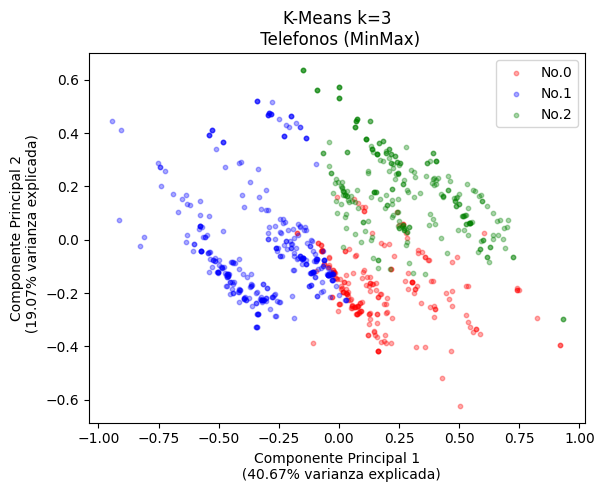

Evaluando métricas para: KMeans k=3, MinMax...
Resultados de 'KMeans k=3, MinMax' agregados.


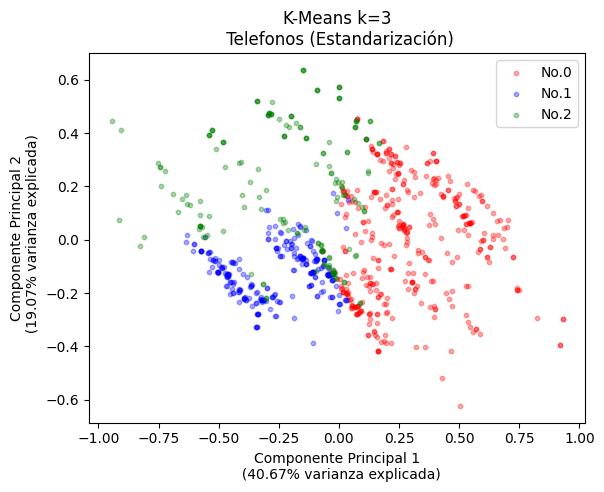

Evaluando métricas para: KMeans k=3, Standard...
Resultados de 'KMeans k=3, Standard' agregados.


In [77]:
# K-Means para los datos con escalado MinMax.
run_name_1 = "KMeans k=3, MinMax"
kmeans = KMeans(n_clusters=3, n_init=100, random_state = 42)
labels_1 = kmeans.fit_predict(datos_escalados_minmax)
df_phones_predict['kmeans_minmax_3'] = labels_1
plot_PCA_labeled(datos_pca_minmax, df_phones_predict['kmeans_minmax_3'], 'K-Means k=3\n Telefonos (MinMax)')
evaluate_and_add_results(all_results, datos_escalados_minmax, labels_1, run_name_1)

# K-Means para los datos con escalado Estandar.
run_name_2 = "KMeans k=3, Standard"
kmeans = KMeans(n_clusters=3, n_init=100, random_state = 42)
labels_2 = kmeans.fit_predict(datos_escalados_standard)
df_phones_predict['kmeans_standard_3'] = labels_2
plot_PCA_labeled(datos_pca_minmax, df_phones_predict['kmeans_standard_3'], 'K-Means k=3\n Telefonos (Estandarización)')
evaluate_and_add_results(all_results, datos_escalados_standard, labels_2, run_name_2)

In [78]:
df_phones_predict.groupby('kmeans_minmax_3').count()

,Company Name,Model Name,Processor,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA),kmeans_standard_3
kmeans_minmax_3,,,,,,,,,,,,,
0,212,212,212,212,212,212,212,212,212,212,212,212,212
1,352,352,352,352,352,352,352,352,352,352,352,352,352
2,265,265,265,265,265,265,265,265,265,265,265,265,265


In [79]:
df_phones_predict.groupby('kmeans_standard_3').count()

,Company Name,Model Name,Processor,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA),kmeans_minmax_3
kmeans_standard_3,,,,,,,,,,,,,
0,381,381,381,381,381,381,381,381,381,381,381,381,381
1,271,271,271,271,271,271,271,271,271,271,271,271,271
2,177,177,177,177,177,177,177,177,177,177,177,177,177


### Segundo Método. Usar Agglomerative Hierarchical Clustering.

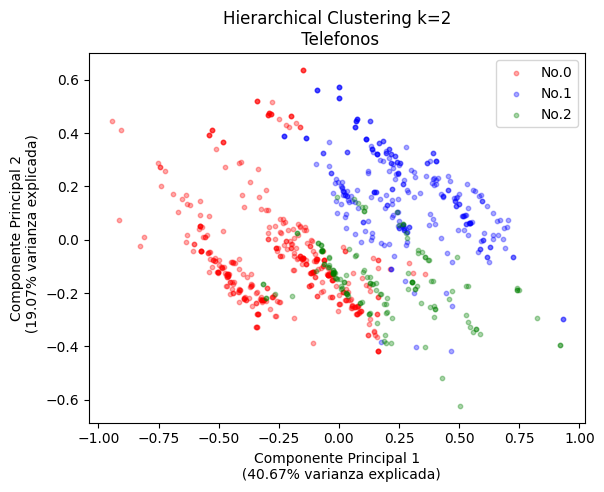

Evaluando métricas para: Agglomerative k=3, MinMax...
Resultados de 'Agglomerative k=3, MinMax' agregados.


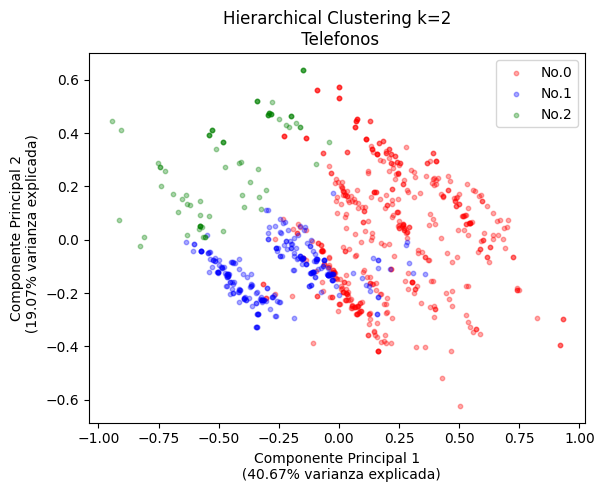

Evaluando métricas para: Agglomerative k=3, Standard...
Resultados de 'Agglomerative k=3, Standard' agregados.


In [80]:
# Agglomerative para los datos con escalado MinMax.
run_name_3 = "Agglomerative k=3, MinMax"
agglomerative = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_3 = agglomerative.fit_predict(datos_escalados_minmax)
df_phones_predict['agglomerative_minmax_3'] = labels_3
plot_PCA_labeled(datos_pca_minmax, df_phones_predict['agglomerative_minmax_3'], 'Hierarchical Clustering k=2\n Telefonos')
evaluate_and_add_results(all_results, datos_escalados_minmax, labels_3, run_name_3)

# Agglomerative para los datos con escalado MinMax.
run_name_4 = "Agglomerative k=3, Standard"
agglomerative = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_4 = agglomerative.fit_predict(datos_escalados_standard)
df_phones_predict['agglomerative_standard_3'] = labels_4
plot_PCA_labeled(datos_pca_minmax, df_phones_predict['agglomerative_standard_3'], 'Hierarchical Clustering k=2\n Telefonos')
evaluate_and_add_results(all_results, datos_escalados_standard, labels_4, run_name_4)

In [81]:
df_phones_predict.groupby('agglomerative_minmax_3').count()

,Company Name,Model Name,Processor,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA),kmeans_minmax_3,kmeans_standard_3,agglomerative_standard_3
agglomerative_minmax_3,,,,,,,,,,,,,,,
0,411,411,411,411,411,411,411,411,411,411,411,411,411,411,411
1,276,276,276,276,276,276,276,276,276,276,276,276,276,276,276
2,142,142,142,142,142,142,142,142,142,142,142,142,142,142,142


In [82]:
df_phones_predict.groupby('agglomerative_standard_3').count()

,Company Name,Model Name,Processor,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA),kmeans_minmax_3,kmeans_standard_3,agglomerative_minmax_3
agglomerative_standard_3,,,,,,,,,,,,,,,
0,485,485,485,485,485,485,485,485,485,485,485,485,485,485,485
1,267,267,267,267,267,267,267,267,267,267,267,267,267,267,267
2,77,77,77,77,77,77,77,77,77,77,77,77,77,77,77


### Tercer método. Usar GMM.

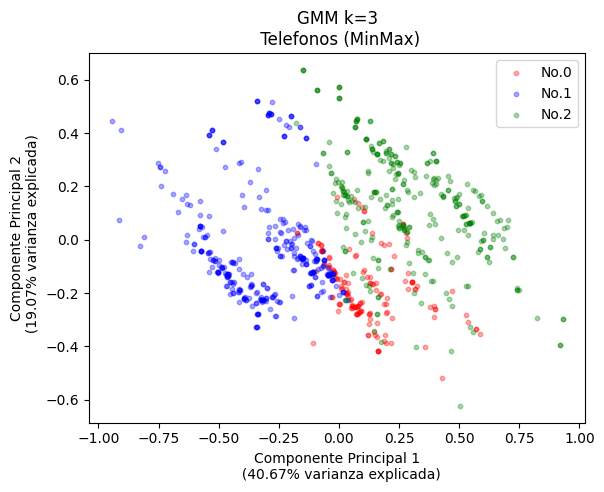

Evaluando métricas para: GMM k=3, MinMax...
Resultados de 'GMM k=3, MinMax' agregados.


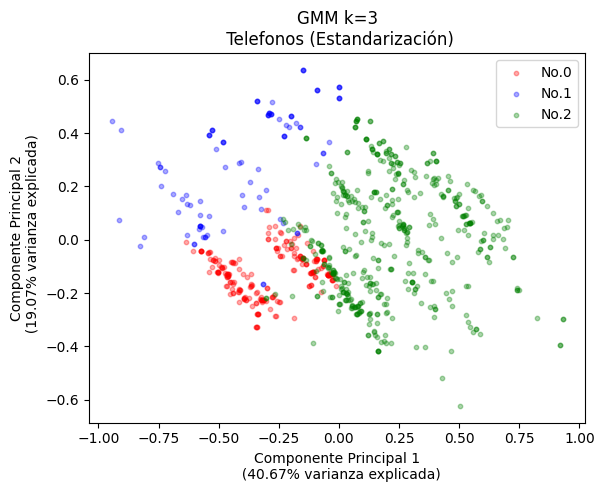

Evaluando métricas para: GMM k=3, Standard...
Resultados de 'GMM k=3, Standard' agregados.


In [83]:
# GMM con datos escalados MinMax.
run_name_5 = "GMM k=3, MinMax"
gmm = GaussianMixture(n_components=3, covariance_type='spherical')
gmm.fit(datos_escalados_minmax)
labels_5 = gmm.predict(datos_escalados_minmax)
df_phones_predict['gmm_minmax_3'] = labels_5
plot_PCA_labeled(datos_pca_minmax, df_phones_predict['gmm_minmax_3'], 'GMM k=3\n Telefonos (MinMax)')
evaluate_and_add_results(all_results, datos_escalados_minmax, labels_5, run_name_5)

# GMM con datos escalados Estandar.
run_name_6 = "GMM k=3, Standard"
gmm = GaussianMixture(n_components=3, covariance_type='spherical')
gmm.fit(datos_escalados_standard)
labels_6 = gmm.predict(datos_escalados_standard)
df_phones_predict['gmm_standard_3'] = labels_6
plot_PCA_labeled(datos_pca_minmax, df_phones_predict['gmm_standard_3'], 'GMM k=3\n Telefonos (Estandarización)')
evaluate_and_add_results(all_results, datos_escalados_standard, labels_6, run_name_6)

In [84]:
df_phones_predict.groupby('gmm_minmax_3').count()

,Company Name,Model Name,Processor,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA),kmeans_minmax_3,kmeans_standard_3,agglomerative_minmax_3,agglomerative_standard_3,gmm_standard_3
gmm_minmax_3,,,,,,,,,,,,,,,,,
0,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161
1,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353,353
2,315,315,315,315,315,315,315,315,315,315,315,315,315,315,315,315,315


In [85]:
df_phones_predict.groupby('gmm_standard_3').count()

,Company Name,Model Name,Processor,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA),kmeans_minmax_3,kmeans_standard_3,agglomerative_minmax_3,agglomerative_standard_3,gmm_minmax_3
gmm_standard_3,,,,,,,,,,,,,,,,,
0,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232,232
1,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
2,497,497,497,497,497,497,497,497,497,497,497,497,497,497,497,497,497


### Análisis de metricas de clustering.

In [86]:
metricas_clustering = np.round(pd.DataFrame(all_results), 3)
metricas_clustering

,"KMeans k=3, MinMax","KMeans k=3, Standard","Agglomerative k=3, MinMax","Agglomerative k=3, Standard","GMM k=3, MinMax","GMM k=3, Standard"
WCSS,123.037,3653.770,133.492,3891.130,125.869,3764.106
Inercia,123.037,3653.770,133.492,3891.130,125.869,3764.106
BCSS,87.761,2149.230,77.306,1911.870,84.930,2038.894
Silhouette,0.269,0.214,0.241,0.186,0.248,0.195
DBI,1.440,1.398,1.423,1.450,1.398,1.362
CHI,294.590,242.936,239.172,202.924,278.672,223.709
BCSS_WCSS_Ratio,0.713,0.588,0.579,0.491,0.675,0.542


### Identificación de los clusters y diseño de una tabla para construir un Dashboard en Tableau.

In [87]:
# Gama media.
gama_media = df_phones_copy[df_phones_predict['kmeans_minmax_3'] == 0]
gama_media

,Company Name,Model Name,Processor,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA)
123,Samsung,Galaxy A54 128GB,Exynos 1380,3.0,189.0,6.0,32,50,5000.0,6.40,2023,399
124,Samsung,Galaxy A54 256GB,Exynos 1380,3.0,189.0,6.0,32,50,5000.0,6.40,2023,449
133,Samsung,Galaxy M54 128GB,Exynos 1380,3.0,202.0,8.0,32,108,6000.0,6.70,2023,349
134,Samsung,Galaxy M54 256GB,Exynos 1380,3.0,202.0,8.0,32,108,6000.0,6.70,2023,399
141,Samsung,Galaxy F54 128GB,Exynos 1380,3.0,199.0,8.0,32,108,6000.0,6.70,2023,349
...,...,...,...,...,...,...,...,...,...,...,...,...
849,Honor,80 Pro,Qualcomm Snapdragon 8+ Gen 1,5.0,193.0,12.0,50,160,4800.0,6.78,2022,799
850,Honor,80 SE,MediaTek Dimensity 900,3.0,175.0,8.0,32,64,4600.0,6.67,2022,399
859,Honor,90,Qualcomm Snapdragon 7 Gen 1,3.0,183.0,12.0,50,200,5000.0,6.70,2023,599
860,Honor,90 Pro,Qualcomm Snapdragon 8+ Gen 1,5.0,192.0,12.0,50,200,5000.0,6.78,2023,699


In [88]:
# Gama baja.
gama_baja = df_phones_copy[df_phones_predict['kmeans_minmax_3'] == 1]
gama_baja

,Company Name,Model Name,Processor,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA)
48,Apple,iPhone 12 mini 64GB,A14 Bionic,4.0,135.0,4.0,12,12,2227.0,5.40,2020,699
49,Apple,iPhone 12 mini 128GB,A14 Bionic,4.0,135.0,4.0,12,12,2227.0,5.40,2020,799
50,Apple,iPhone 12 mini 256GB,A14 Bionic,4.0,135.0,4.0,12,12,2227.0,5.40,2020,899
51,Apple,iPhone 12 64GB,A14 Bionic,4.0,164.0,4.0,12,12,2815.0,6.10,2020,799
52,Apple,iPhone 12 128GB,A14 Bionic,4.0,164.0,4.0,12,12,2815.0,6.10,2020,899
...,...,...,...,...,...,...,...,...,...,...,...,...
914,POCO,X5 Pro 128GB,Snapdragon 778G,3.0,181.0,6.0,16,108,5000.0,6.67,2023,329
915,POCO,M6 64GB,MediaTek Helio G88,2.0,199.0,4.0,8,50,5000.0,6.58,2023,199
916,POCO,M6 Pro 128GB,Snapdragon 4 Gen 1,3.0,202.0,6.0,8,50,5000.0,6.79,2023,219
921,POCO,C65 64GB,MediaTek Helio G85,2.0,190.0,4.0,5,50,5000.0,6.50,2024,149


In [89]:
# Gama alta.
gama_alta = df_phones_copy[df_phones_predict['kmeans_minmax_3'] == 2]
gama_alta

,Company Name,Model Name,Processor,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA)
0,Apple,iPhone 16 128GB,A17 Bionic,5.0,174.0,6.0,12,48,3600.0,6.10,2024,799
1,Apple,iPhone 16 256GB,A17 Bionic,5.0,174.0,6.0,12,48,3600.0,6.10,2024,849
2,Apple,iPhone 16 512GB,A17 Bionic,5.0,174.0,6.0,12,48,3600.0,6.10,2024,899
3,Apple,iPhone 16 Plus 128GB,A17 Bionic,5.0,203.0,6.0,12,48,4200.0,6.70,2024,899
4,Apple,iPhone 16 Plus 256GB,A17 Bionic,5.0,203.0,6.0,12,48,4200.0,6.70,2024,949
...,...,...,...,...,...,...,...,...,...,...,...,...
922,POCO,X7 128GB,MediaTek Dimensity 8200,4.0,195.0,6.0,16,64,5000.0,6.67,2025,329
923,POCO,X7 Pro 256GB,MediaTek Dimensity 8400,5.0,207.0,8.0,20,108,6000.0,6.67,2025,399
927,Samsung,Galaxy Z Fold6 256GB,Snapdragon 8 Gen 3,5.0,239.0,12.0,10,50,4400.0,7.60,2024,1899
928,Samsung,Galaxy Z Fold6 512GB,Snapdragon 8 Gen 3,5.0,239.0,12.0,10,50,4400.0,7.60,2024,1719


In [91]:
gama_alta.describe().loc[['min','mean', 'max']]

,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA)
min,3.000000,140.000000,4.000000,8.000000,12.000000,2438.000000,5.40000,2018.000000,249.000000
mean,4.641509,204.833962,9.977358,17.132075,53.962264,4693.369811,6.69366,2022.762264,977.569811
max,5.000000,295.000000,16.000000,32.000000,200.000000,6500.000000,8.00000,2025.000000,2799.000000


In [92]:
gama_media.describe().loc[['min','mean', 'max']]

,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA)
min,2.000000,155.000000,6.000000,16.000000,40.00000,3700.000000,6.280000,2019.000000,199.000000
mean,3.349057,187.391509,9.471698,34.933962,67.95283,4708.254717,6.641509,2022.481132,522.617925
max,5.000000,288.000000,16.000000,60.000000,200.00000,6000.000000,7.900000,2025.000000,1799.000000


In [93]:
gama_baja.describe().loc[['min','mean', 'max']]

,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Year,Launched Price (USA)
min,1.000000,135.000000,1.0000,5.000000,8.000000,2000.000000,5.000000,2014.000000,79.00
mean,2.607955,188.630682,5.4375,11.721591,37.860795,4617.670455,6.472131,2021.565341,336.25
max,4.000000,235.000000,8.0000,32.000000,108.000000,6000.000000,7.090000,2025.000000,1399.00


In [96]:
gama_baja["Gama"] = "Baja"
gama_media["Gama"] = "Media"
gama_alta["Gama"] = "Alta"
df_analytics = pd.concat([gama_alta, gama_media, gama_baja],axis=0,
    ignore_index=True)
df_analytics = df_analytics[['Company Name', 'Model Name', 'Launched Year', 'Launched Price (USA)', 'Processor', 'ProcessorBench',	'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Battery Capacity',	'Screen Size', 'Gama']]
df_analytics.to_excel("df_analytics.xlsx")
df_analytics

/tmp/ipython-input-4145275631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gama_baja["Gama"] = "Baja"
/tmp/ipython-input-4145275631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gama_media["Gama"] = "Media"
/tmp/ipython-input-4145275631.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

,Company Name,Model Name,Launched Year,Launched Price (USA),Processor,ProcessorBench,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Gama
0,Apple,iPhone 16 128GB,2024,799,A17 Bionic,5.0,174.0,6.0,12,48,3600.0,6.10,Alta
1,Apple,iPhone 16 256GB,2024,849,A17 Bionic,5.0,174.0,6.0,12,48,3600.0,6.10,Alta
2,Apple,iPhone 16 512GB,2024,899,A17 Bionic,5.0,174.0,6.0,12,48,3600.0,6.10,Alta
3,Apple,iPhone 16 Plus 128GB,2024,899,A17 Bionic,5.0,203.0,6.0,12,48,4200.0,6.70,Alta
4,Apple,iPhone 16 Plus 256GB,2024,949,A17 Bionic,5.0,203.0,6.0,12,48,4200.0,6.70,Alta
...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,POCO,X5 Pro 128GB,2023,329,Snapdragon 778G,3.0,181.0,6.0,16,108,5000.0,6.67,Baja
825,POCO,M6 64GB,2023,199,MediaTek Helio G88,2.0,199.0,4.0,8,50,5000.0,6.58,Baja
826,POCO,M6 Pro 128GB,2023,219,Snapdragon 4 Gen 1,3.0,202.0,6.0,8,50,5000.0,6.79,Baja
827,POCO,C65 64GB,2024,149,MediaTek Helio G85,2.0,190.0,4.0,5,50,5000.0,6.50,Baja


## Patrones Identificados:

Tras analizar las características por grupo, se identificaron patrones con potenciales aplicaciones como:

- La gama donde se presenta mayor concentración de dispositivos móviles es en la gama baja.
- El promedio de teléfonos de gama media y de gama baja tienen casi las mismas características de hardware que el promedio de teléfonos de gama alta por casi menos de la mitad de precio.
- La batería con la que cuentan las 3 gamas en general se mantiene en los mismos rangos, así todas las gamas ofrecen casi el mismo rendimiento de batería.
- El tamaño de pantalla se mantiene casi constante para las tres gamas, indicando que no es un factor relevante al clasificar teléfonos.
- Los teléfonos de gama media superan a los de gama alta en megapíxeles, pero esto no necesariamente indica que tengan mayor cámara, pues generalmente los de gama alta tienen mejores sensores. Puede resultar más en un tema de mercadotecnia para hacer más atractiva la gama media.
- Los teléfonos de gama alta se diferencian principalmente sobre las otras dos gamas por que ofrecen mayor capacidad de procesamiento.


